In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
from datetime import datetime, timedelta
import numpy as np

In [2]:
# starting with choosing a stock (.IS refers to Turkey's stock market index, BIST)

stock = web.DataReader('GARAN.IS','yahoo', start=datetime(2018,1,1)-timedelta(days=27))

# substracted 27 days in order to have significant values for first 20 days, we will be dropping these after we
# calculate the 20 days rolling average and standart deviation

stock['Rolling 20 Open Mean'] = stock['Open'].rolling(20).mean()
stock['Rolling 20 Open STD']  = stock['Open'].rolling(20).std()


stock.dropna(inplace=True)

# bollinger bands suggests that prices are too high when they go above the upper band of bollinger band, so one should
# take short position. Inversely, if prices drop below lower bands, it is time to go long:

conditions = [(stock['Open'] < stock['Rolling 20 Open Mean'] + 2*stock['Rolling 20 Open STD']) & (stock['Open'] > stock['Rolling 20 Open Mean'] - 2*stock['Rolling 20 Open STD']),

              (stock['Open'] > stock['Rolling 20 Open Mean'] + 2*stock['Rolling 20 Open STD']),
              
              (stock['Open'] < stock['Rolling 20 Open Mean'] - 2*stock['Rolling 20 Open STD'])]

choices = [0,-1, 1]

stock['Bollinger Decision'] = np.select(conditions,choices)

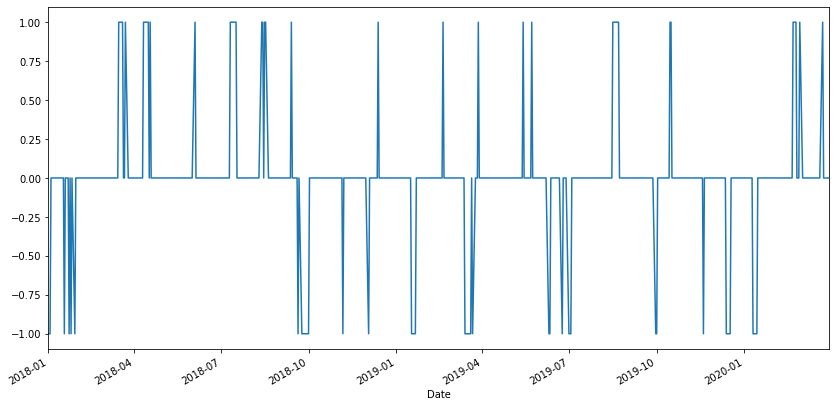

In [3]:
# taking a look at "signals" given by bollinger bands
stock['Bollinger Decision'].plot(figsize=(14,7))

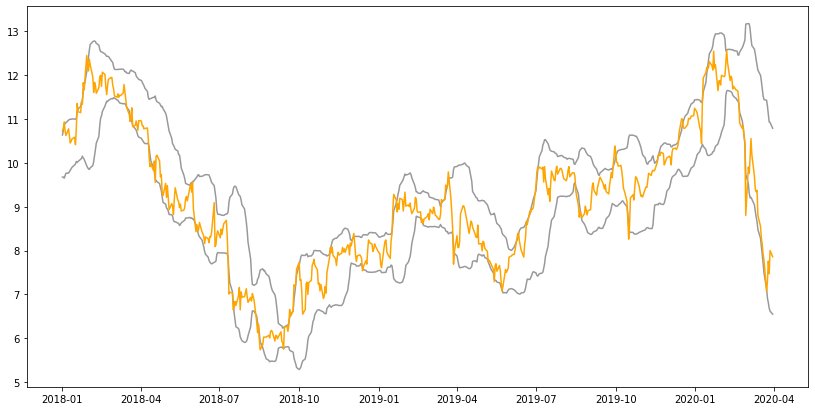

In [4]:
# bollinger bands
fig = plt.figure(figsize=(14,7))
plt.plot(stock['Rolling 20 Open Mean'] + 2*stock['Rolling 20 Open STD'],color='gray',alpha=0.8)
plt.plot(stock['Rolling 20 Open Mean'] - 2*stock['Rolling 20 Open STD'],color='gray',alpha=0.8)
plt.plot(stock['Open'],color='orange')

# defining the bollinger_map

In [5]:
def bollinger_map(asset_name, bollinger_day_count, days_to_wait, start_date, end_date=datetime.now()):
    """
    This function sets up bollinger bands by looking at open prices.
    
    Parameters
    ----------    
    asset_name          : takes string value for stock name
    bollinger_day_count : day count for rolling mean open price
    days_to_wait        : days to hold the position
    start_date          : takes datetime values
    end_date            : takes today's date by default
    """

    import pandas as pd
    import pandas_datareader.data as web
    from datetime import datetime, timedelta
    from numpy import select
    from math import floor
    import matplotlib.pyplot as plt
    
    stock = web.DataReader(asset_name,'yahoo', start=start_date-timedelta(days=27), end=end_date)
    
    stock['Rolling Mean Open Price'] = stock['Open'].rolling(bollinger_day_count).mean()
    stock['Rolling STD Open Price']  = stock['Open'].rolling(bollinger_day_count).std()
    
    stock.dropna(inplace=True)

    conditions = [(stock['Open'] < stock['Rolling Mean Open Price'] + 2*stock['Rolling STD Open Price']) & (stock['Open'] > stock['Rolling Mean Open Price'] - 2*stock['Rolling STD Open Price']),

                 (stock['Open'] > stock['Rolling Mean Open Price'] + 2*stock['Rolling STD Open Price']),

                 (stock['Open'] < stock['Rolling Mean Open Price'] - 2*stock['Rolling STD Open Price'])]

    choices = [0,-1, 1]

    stock['Bollinger Decision'] = select(conditions,choices)

    maxprices = []
    i = 0
    while i<len(stock):
        maxprices.append(max(stock['Open'].iloc[i:i+days_to_wait]))
        i = i+1

    stock['Max Prices in Interval'] = maxprices

##    stock = stock[:-days_to_wait]

    fig,ax = plt.subplots(figsize=(14,7))
    ax.plot(stock['Rolling Mean Open Price'] + 2*stock['Rolling STD Open Price'],color='gray',alpha=0.8)
    ax.plot(stock['Rolling Mean Open Price'] - 2*stock['Rolling STD Open Price'],color='gray',alpha=0.8)
    ax.plot(stock['Open'],color='orange')

    each = 0
    while each < len(stock[stock['Bollinger Decision']==1]):
        ax.axvspan(stock[stock['Bollinger Decision']==1].index[each],stock[stock['Bollinger Decision']==1].index[each]+timedelta(days=days_to_wait),
            facecolor='blue', alpha=0.1)
        each = each + 1

    each = 0
    while each < len(stock[stock['Bollinger Decision']==-1]):
        ax.axvspan(stock[stock['Bollinger Decision']==-1].index[each],stock[stock['Bollinger Decision']==-1].index[each]+timedelta(days=days_to_wait),
            facecolor='red', alpha=0.1)
        each = each + 1

    print('Success rate is: ', round((len(stock[(stock['Bollinger Decision']==1) & (stock['Open']<stock['Max Prices in Interval'])])+len(stock[(stock['Bollinger Decision']==-1) & (stock['Open'] < stock['Max Prices in Interval'])])) /(len(stock[stock['Bollinger Decision']==1]) + len(stock[stock['Bollinger Decision']==-1])),2)*100,'%',sep='')

Success rate is: 86.0%


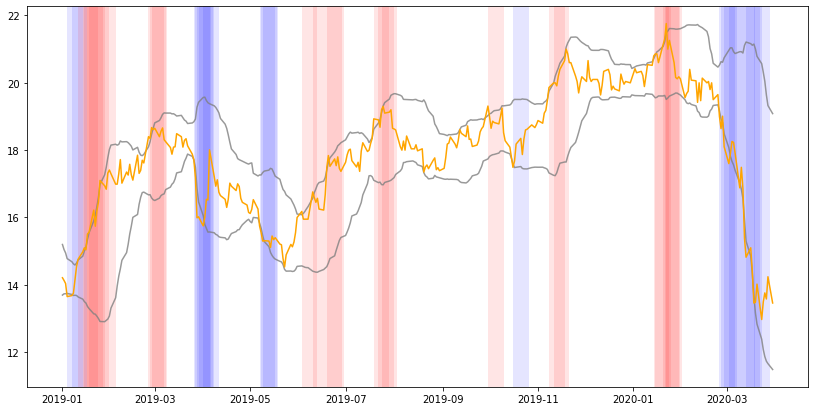

In [6]:
# we defined a function which would show the "heated" areas in red and "cold" areas in blue. These areas show up when
# prices go above or below the bollinger bands. Also, it gives a success rate which shows how many times bollinger 
# bands were right about taking a position on the stock

# now, let'z look at a another Turkish stock, and see its "heat map" on bollinger bands:

bollinger_map('KCHOL.IS',20,10,datetime(2019,1,1))